In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils
import torch.distributions

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))



Using cpu device


# Data generation

Geometrical figures of random position, shape and color

Random Color:


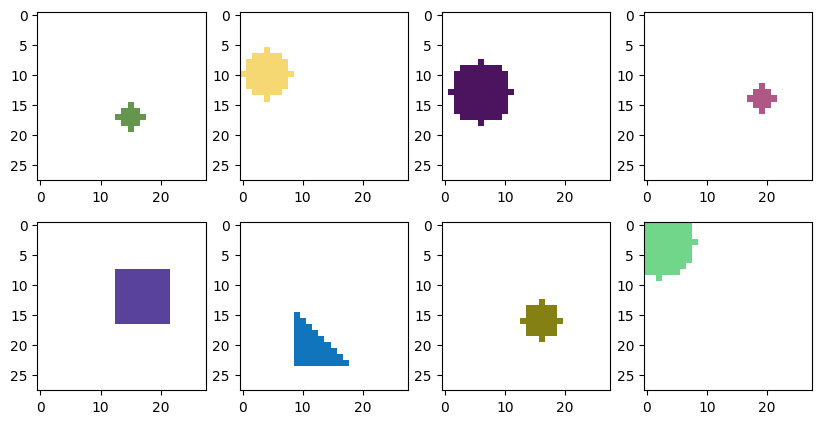

In [32]:


class GeometricFiguresDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=60000, image_size=(28, 28), random_color=True):
        self.num_samples = num_samples
        self.image_size = image_size
        self.random_color = random_color

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, label = self.generate_image()
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        label_tensor = torch.tensor(label)
        return image_tensor, label_tensor

    def generate_image(self):
        image = np.ones((self.image_size[0], self.image_size[1], 3), dtype=np.uint8) * 255  # White background

        shape = np.random.choice(['square', 'circle', 'triangle'])
        color = self.choose_color()
        size = np.random.randint(3, self.image_size[0] // 2)
        pos_x = np.random.randint(0, self.image_size[1] - size)
        pos_y = np.random.randint(0, self.image_size[0] - size)

        if shape == 'square':
            image = self.draw_square(image, x = pos_x, y = pos_y,  size=size, color=color)
        elif shape=='circle':
            image = self.draw_circle(image, x = pos_x, y = pos_y, radius=size//2, color=color)
        else:
            image = self.draw_triangle(image, x = pos_x, y = pos_y, size=size, color=color)

        #label is the shape, color, size and position of the shape
        shape_dict = {'square': 0, 'circle': 1, 'triangle': 2}
        label = np.array([shape_dict[shape],  size, pos_x, pos_y, color[0], color[1], color[2]])


        return image, label

    def choose_color(self):
        if self.random_color:
            return np.random.randint(0, 256, size=3)  # Random RGB color
        else:
            color_r = np.array([255, 0, 0])
            color_g = np.array([0, 255, 0])
            color_b = np.array([0, 0, 255])
            rand_col = np.random.randint(0, 3)
            if rand_col == 0:
                return color_r
            elif rand_col == 1:
                return color_g
            else:
                return color_b


    def draw_square(self, image, x, y, size, color):
        image[y:y+size, x:x+size] = color
        return image

    def draw_triangle(self, image, x, y, size, color):
        image[y:y+size, x:x+size] = color

        # Determine whether to remove upper or lower half of the square
        if np.random.rand() < 0.5:
            # Remove upper half of the square
            for i in range(size):
                for j in range(size):
                    if i > j:
                        image[y+i, x+j] = 255  # Background color
        else:
            # Remove lower half of the square
            for i in range(size):
                for j in range(size):
                    if i < j:
                        image[y+i, x+j] = 255  # Background color
        return image

    def draw_circle(self, image, x, y, radius, color):

        yy, xx = np.ogrid[-y:image.shape[0]-y, -x:image.shape[1]-x]
        mask = xx*xx + yy*yy <= radius*radius
        image[mask] = color
        return image


class GeometricFiguresDatasetBlackWhite(GeometricFiguresDataset):
    def __init__(self, num_samples=60000, image_size=(28, 28)):
        super().__init__(num_samples, image_size, random_color=False)

    def choose_color(self):
        return np.array([0, 0, 0])  # Black color

    def __getitem__(self, idx):
        img, label =  super().__getitem__(idx)
        img = img[0]  # Take only one channel
        img = img/255.0  # Normalize
        return img, label




dataset_random_color = GeometricFiguresDataset(random_color=True)
dataloader_random_color = torch.utils.data.DataLoader(dataset_random_color, batch_size=8, shuffle=True)

# Visualize some samples with random color
print("Random Color:")
for batch in dataloader_random_color:
    batch = batch[0]
    plt.figure(figsize=(10, 5))
    for i in range(batch.size(0)):
        plt.subplot(2, 4, i+1)
        plt.imshow(batch[i].permute(1, 2, 0).numpy())
        #plt.axis('off')
    plt.show()
    break  # Only visualize one batch


define train data

In [33]:
batch_size = 128

dataset = GeometricFiguresDataset(random_color=True, num_samples=20000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


----

# My Variational Autoencoder

In [34]:
class VAE_encoder(nn.Module):

    def __init__(self, image_channels = 3):
        super(VAE_encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 16, kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten() # 64*3*3 = 576 #calc sizes using https://madebyollin.github.io/convnet-calculator/
        )
    
    def forward(self, x):
        h = self.encoder(x)
        return h
    

class VAE_decoder(nn.Module):
    def __init__(self, image_channels = 3):
        super(VAE_decoder, self).__init__()

        self.unflatten = nn.Unflatten(1, [64, 3, 3])
        self.decoder = nn.Sequential(
            self.unflatten,
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, image_channels, kernel_size=4, stride=2, padding=2),
            nn.BatchNorm2d(image_channels),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        z = self.decoder(z)
        return z

class VAE(nn.Module):
    def __init__(self, image_channels = 3, hidden_dim = 576, latent_dim = 64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = VAE_encoder(image_channels)
        self.decoder = VAE_decoder(image_channels)
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        self.fc_decoder = nn.Linear(latent_dim, hidden_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z

    def decode(self, z):
        hidden = self.fc_decoder(z)
        x_recon = self.decoder(hidden)
        return x_recon
      
    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = self.fc_mu(h), self.fc_log_var(h)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var
    

    def forward(self, x):
        z, mu, log_var = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, mu, log_var


class AE(nn.Module):
    def __init__(self, image_channels = 3, hidden_dim = 576):
        super(AE, self).__init__()
        self.encoder = VAE_encoder(image_channels)
        self.decoder = VAE_decoder(image_channels)
        
        self.fc_decoder = nn.Linear(hidden_dim, hidden_dim)

    def decode(self, z):
        hidden = self.fc_decoder(z)
        x_recon = self.decoder(hidden)
        return x_recon
      
    def encode(self, x):
        h = self.encoder(x)
        return h

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon



enc = VAE_encoder()
dec = VAE_decoder()
vae = VAE()
ae = AE()

rand_inp = torch.randn(8, 3, 28, 28)
enc_out = enc(rand_inp)
dec_out = dec(enc_out)
vae_out, mu, log_var = vae(rand_inp)
ae_out = ae(rand_inp)

print(rand_inp.shape, enc_out.shape, dec_out.shape, vae_out.shape, mu.shape, log_var.shape, ae_out.shape)
assert dec_out.shape == rand_inp.shape, f"Expected: {rand_inp.shape}, Got: {dec_out.shape}"


vae = vae.to(device)



torch.Size([8, 3, 28, 28]) torch.Size([8, 576]) torch.Size([8, 3, 28, 28]) torch.Size([8, 3, 28, 28]) torch.Size([8, 64]) torch.Size([8, 64]) torch.Size([8, 3, 28, 28])


torch.Size([128, 3, 28, 28])


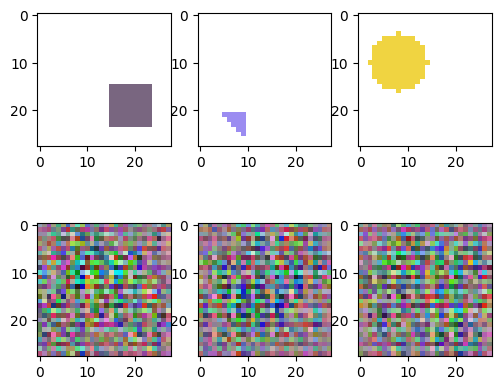

In [35]:

random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output = vae(random_batch)[0]


print(output.shape)
assert output.shape == random_batch.shape, f"Expected output shape {random_batch.shape} but got {output.shape}"


plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())


In [36]:
def loss_fn(recon_x, x, mu, logvar, KL_weight = 1.0):
    BCE = F.binary_cross_entropy(recon_x, x)
    # BCE = F.mse_loss(recon_x, x)

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KL_weight*KLD, BCE, KLD

In [37]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [38]:
num_epochs = 5
KL_weight = 1


for epoch in range(num_epochs):
    running_loss = 0.0
    running_KL = 0.0
    running_recon = 0.0

    for images, labels in dataloader:
        images = images.to(device)

        optimizer.zero_grad()
        outputs = vae(images)
        recon_x = outputs[0]
        mu = outputs[1]
        logvar = outputs[2]
        loss, KL, RECON = loss_fn(recon_x=recon_x, x = images, mu = mu, logvar = logvar, KL_weight = KL_weight)

        loss.backward()
        optimizer.step()

        running_KL += KL.item() * images.size(0)
        running_recon += RECON.item() * images.size(0)
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_KL = running_KL / len(dataloader.dataset)
    epoch_recon = running_recon / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}, KL: {epoch_KL:.5f}, Recon: {epoch_recon:.5f}")

Epoch [1/5], Loss: 40.86308, KL: 0.68866, Recon: 40.17442
Epoch [2/5], Loss: 1.54687, KL: 0.60136, Recon: 0.94550
Epoch [3/5], Loss: 1.05434, KL: 0.54121, Recon: 0.51313
Epoch [4/5], Loss: 0.82697, KL: 0.48939, Recon: 0.33758
Epoch [5/5], Loss: 0.69361, KL: 0.44600, Recon: 0.24761


torch.Size([128, 3, 28, 28]) torch.Size([128, 3, 28, 28])


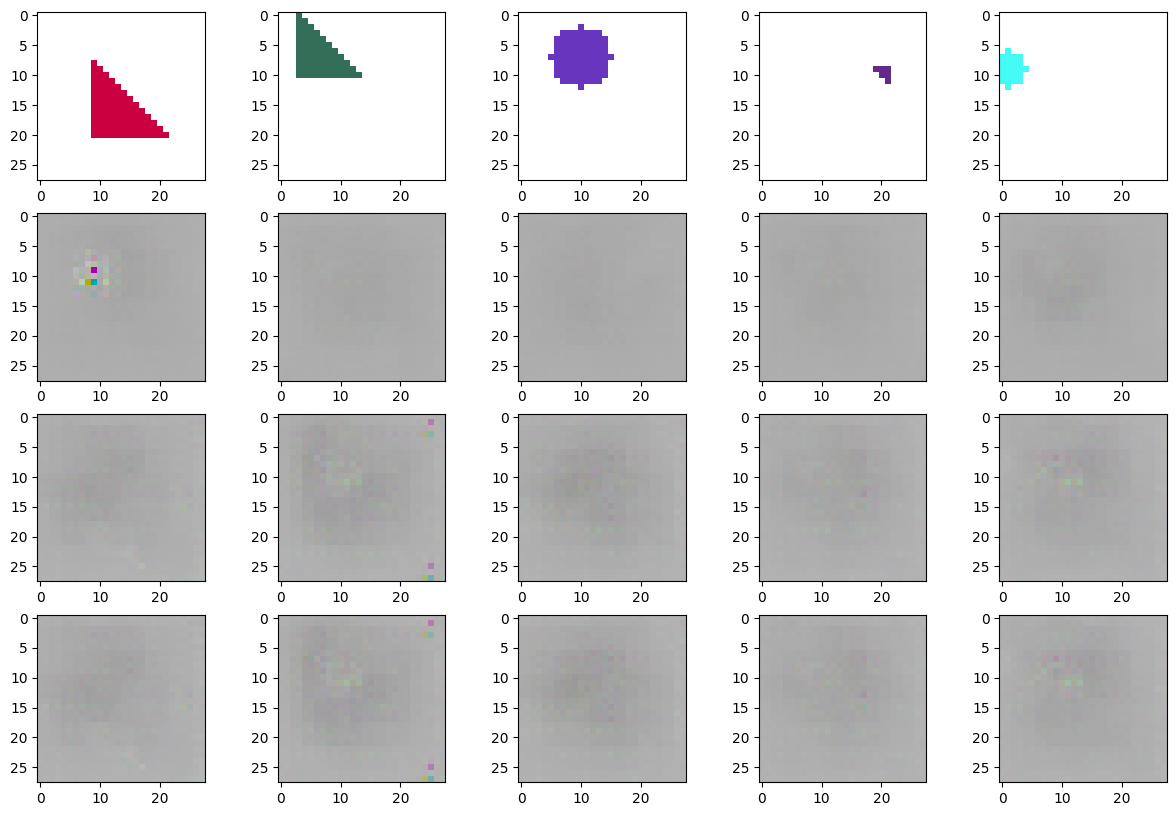

In [39]:
random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output, mu, logvar = vae(random_batch)
print(output.shape, random_batch.shape)

z = vae.reparameterize(mu, logvar)
output_sampled = vae.decode(z)

z_2 = vae.reparameterize(mu, logvar)
output_sampled_2 = vae.decode(z)


plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(4, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(4, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(4, 5, i+11)
    plt.imshow(output_sampled[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(4, 5, i+16)
    plt.imshow(output_sampled_2[i].permute(1, 2, 0).cpu().detach().numpy())



# Variational Autoencoder from a github repository

In [40]:


class VAE_other(nn.Module):
    #https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb
    def __init__(self, image_channels=3, h_dim=576, z_dim=64):
        super(VAE_other, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 16, kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.unflatten = nn.Unflatten(1, [64, 3, 3])

        self.decoder = nn.Sequential(
            self.unflatten,
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, image_channels, kernel_size=4, stride=2, padding = 2),
            nn.BatchNorm2d(image_channels),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_().to(device)
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
    
vae_other = VAE_other(image_channels=3).to(device)


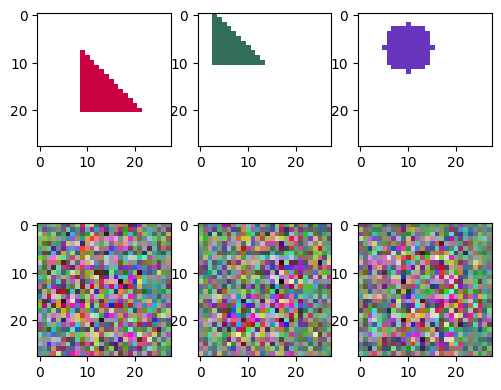

In [41]:
output = vae_other(random_batch)[0]

plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())


In [42]:
def loss_fn_other(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [43]:
optimizer_other = torch.optim.Adam(vae_other.parameters(), lr=1e-3)

In [44]:
num_epochs = 5
KL_weight = 1


for epoch in range(num_epochs):
    running_loss = 0.0
    running_KL = 0.0
    running_recon = 0.0

    for images, labels in dataloader:
        images = images.to(device)

        optimizer_other.zero_grad()
        outputs = vae_other(images)
        recon_x = outputs[0]
        mu = outputs[1]
        logvar = outputs[2]
        loss, KL, RECON = loss_fn(recon_x=recon_x, x = images, mu = mu, logvar = logvar, KL_weight = KL_weight)

        loss.backward()
        optimizer_other.step()

        running_KL += KL.item() * images.size(0)
        running_recon += RECON.item() * images.size(0)
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_KL = running_KL / len(dataloader.dataset)
    epoch_recon = running_recon / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}, KL: {epoch_KL:.5f}, Recon: {epoch_recon:.5f}")

Epoch [1/5], Loss: 50.30406, KL: 0.69165, Recon: 49.61241
Epoch [2/5], Loss: 1.79284, KL: 0.60233, Recon: 1.19050
Epoch [3/5], Loss: 1.13515, KL: 0.54172, Recon: 0.59343
Epoch [4/5], Loss: 0.88167, KL: 0.48951, Recon: 0.39216
Epoch [5/5], Loss: 0.72599, KL: 0.44690, Recon: 0.27909


torch.Size([128, 3, 28, 28]) torch.Size([128, 3, 28, 28])


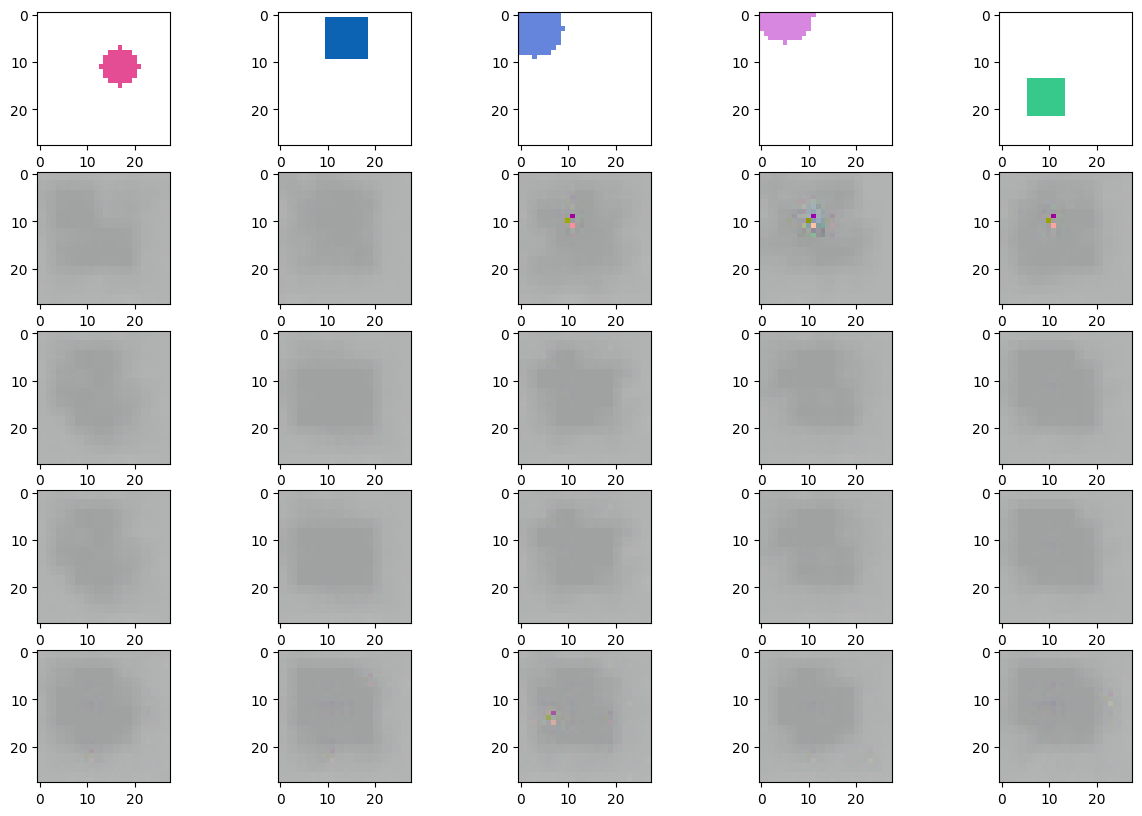

In [59]:
random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output, mu, logvar = vae_other(random_batch)
print(output.shape, random_batch.shape)

z = vae_other.reparameterize(mu, logvar)
output_sampled = vae_other.decode(z)

z_2 = vae_other.reparameterize(mu, logvar)
output_sampled_2 = vae_other.decode(z)

z_random = torch.randn_like(z)
output_random = vae_other.decode(z_random)


plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(5, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(5, 5, i+11)
    plt.imshow(output_sampled[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(5, 5, i+16)
    plt.imshow(output_sampled_2[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(5, 5, i+21)
    plt.imshow(output_random[i].permute(1, 2, 0).cpu().detach().numpy())



# More powerful VAE from gihub repository

In [49]:
class VAE_other_2(nn.Module):
    def __init__(self, image_channels=3, h_dim=256, z_dim=32):
        super(VAE_other_2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.unflatten = nn.Unflatten(1, [256, 1, 1])
        self.decoder = nn.Sequential(
            self.unflatten,
            nn.ConvTranspose2d(h_dim, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=2),
            nn.BatchNorm2d(image_channels),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_().to(device)
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

torch.Size([128, 3, 28, 28])


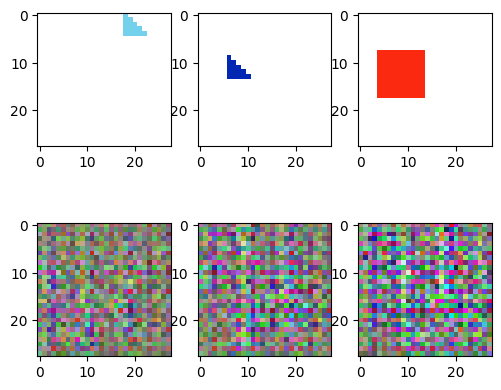

In [53]:
vae_other_2 = VAE_other_2(image_channels=3).to(device)



random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output = vae_other_2(random_batch)[0]


print(output.shape)
assert output.shape == random_batch.shape, f"Expected output shape {random_batch.shape} but got {output.shape}"


plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())


In [54]:
optimizer_other_2 = torch.optim.Adam(vae_other_2.parameters(), lr=1e-3)

In [55]:
def loss_fn_other_2(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [56]:
num_epochs = 5
KL_weight = 1


for epoch in range(num_epochs):
    running_loss = 0.0
    running_KL = 0.0
    running_recon = 0.0

    for images, labels in dataloader:
        images = images.to(device)

        optimizer_other_2.zero_grad()
        outputs = vae_other_2(images)
        recon_x = outputs[0]
        mu = outputs[1]
        logvar = outputs[2]
        loss, KL, RECON = loss_fn_other_2(recon_x=recon_x, x = images, mu = mu, logvar = logvar)

        loss.backward()
        optimizer_other_2.step()

        running_KL += KL.item() * images.size(0)
        running_recon += RECON.item() * images.size(0)
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_KL = running_KL / len(dataloader.dataset)
    epoch_recon = running_recon / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}, KL: {epoch_KL:.5f}, Recon: {epoch_recon:.5f}")

/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch [1/5], Loss: 197582.52396, KL: 197343.51674, Recon: 239.00693
Epoch [2/5], Loss: 171490.24622, KL: 171488.01112, Recon: 2.23530
Epoch [3/5], Loss: 153304.17292, KL: 153301.49830, Recon: 2.67460
Epoch [4/5], Loss: 137189.09318, KL: 137185.92491, Recon: 3.16850
Epoch [5/5], Loss: 124020.00067, KL: 124016.48985, Recon: 3.51076


torch.Size([128, 3, 28, 28]) torch.Size([128, 3, 28, 28])


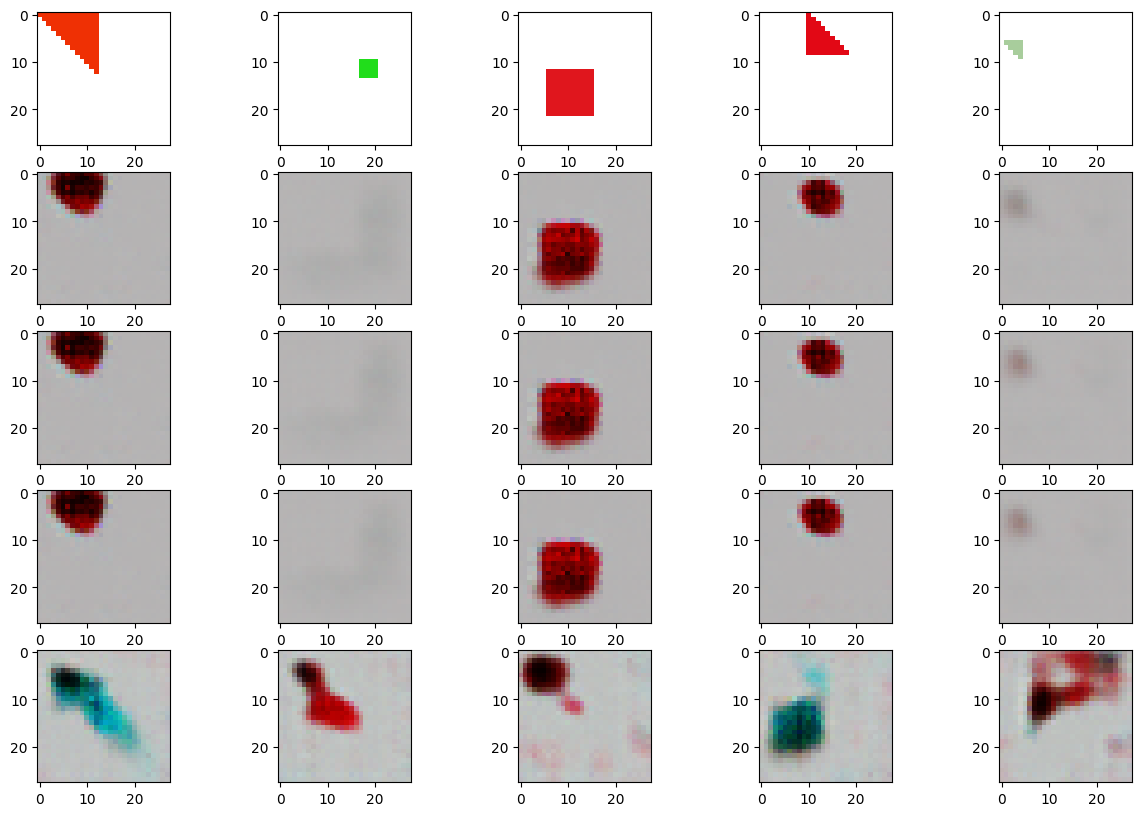

In [63]:
random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output, mu, logvar = vae_other_2(random_batch)
print(output.shape, random_batch.shape)

z = vae_other_2.reparameterize(mu, logvar)
output_sampled = vae_other_2.decode(z)

z_2 = vae_other_2.reparameterize(mu, logvar)
output_sampled_2 = vae_other_2.decode(z)

z_random = torch.randn_like(z)
output_random = vae_other_2.decode(z_random)


plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(5, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(5, 5, i+11)
    plt.imshow(output_sampled[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(5, 5, i+16)
    plt.imshow(output_sampled_2[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(5, 5, i+21)
    plt.imshow(output_random[i].permute(1, 2, 0).cpu().detach().numpy())

